In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import cv2
%matplotlib inline

In [3]:
original_x = np.load('datasets/original_x.npy')
original_y = np.load('datasets/original_y.npy')
original_x.shape,original_y.shape

((3000, 28, 28), (3000,))

In [4]:
num = 5
np.random.seed(19)
#np.array([0,1,2]).reshape(1,-1)*np.ones((50,3))).reshape(5,30).astype('int32')
random_idx = ((np.asarray([i+j for i in range(0,600,150) for j in range(15)])[np.asarray([np.random.choice(60,size=num,replace=False) for i in range(10) for j in range(5)]).reshape(5,10*num)]+((np.arange(10)*15).reshape(-1,1)*np.ones(num)).reshape(1,-1))+((np.arange(5)*600).reshape(-1,1)*np.ones(num*10))).ravel().astype('int32')
x_train = original_x[np.array([i for i in range(original_x.shape[0]) if not i in random_idx])]
y_train = original_y[np.array([i for i in range(original_x.shape[0]) if not i in random_idx])]
x_val = original_x[random_idx]
y_val = original_y[random_idx]

x_train.shape,y_train.shape,x_val.shape,y_val.shape

((2750, 28, 28), (2750,), (250, 28, 28), (250,))

In [51]:
class generater:
    def __init__(self, samples_num, shape_0, shape_1):
        self.aim_date = np.zeros((samples_num,shape_0,shape_1),dtype='uint8')
        self.aim_ground_truth = np.zeros((samples_num),dtype='int32').tolist()
        self.samples_num = samples_num
        self.shape_0 = shape_0
        self.shape_1 = shape_1
        self.spacing_get = True
        self.the0 = 100
        self.the1 = 3
        self.get_config()
        
    def get_config(self, scale_range=(0.5,2), is_cube=True, spacing_range=36, rotation_range=(-15,15), rotation_cut=True, num_range=(4,6)):
        self.scale_range = scale_range
        self.is_cube = is_cube
        self.spacing_range = spacing_range
        self.rotation_range = rotation_range
        self.rotation_cut = rotation_cut
        self.num_range = num_range
        
    def fit_and_generater(self, x, y, random_state=19):
        np.random.seed(random_state)
        for i in range(self.samples_num):    
            batch_num = np.random.randint(self.num_range[0],self.num_range[1]+1)
            batch_index = np.random.choice(x.shape[0], batch_num, replace=False)           
            batch_date = np.zeros(batch_num,dtype='int32').tolist()
            rotation_range = np.random.uniform(self.rotation_range[0],self.rotation_range[1],(batch_num))
            scale_range = 28*(np.random.uniform(self.scale_range[0],self.scale_range[1],(batch_num))+1)            
            if self.is_cube:
                scale_range = np.tile(scale_range,2).astype('int32')                
            else:
                scale_range = np.concatenate((scale_range,28*(np.random.uniform(-self.scale_range,self.scale_range,(batch_num))+1))).astype('int32')       
            batch_ground_truth = np.zeros(batch_num,dtype='int32').tolist()
            batch_xy = np.zeros((batch_num,2),dtype='int32')
            x_left,y_left,x_right,y_right=np.zeros(batch_num, dtype='int32'),np.zeros(batch_num, dtype='int32'),np.zeros(batch_num, dtype='int32'),np.zeros(batch_num, dtype='int32')
            ys,xs = 0,0
            for j in range(batch_num):                
                batch_date[j] = np.asarray(image.fromarray(x[batch_index[j]].astype('uint8')).resize((scale_range[j],scale_range[j+batch_num])).rotate(rotation_range[j],expand=self.is_cube))
                for it in range(10000):
                    batch_xy[j,0] = np.random.randint(0,np.clip(self.shape_1-batch_date[j].shape[1],1,200),dtype='int32')
                    batch_xy[j,1] = np.random.randint(0,np.clip(self.shape_0-batch_date[j].shape[0],1,200),dtype='int32')
                    ys,xs = np.split(np.argwhere(batch_date[j]>self.the0),2,axis=1)
                    x_left[j],y_left[j],x_right[j],y_right[j] = xs.min()-self.the1+batch_xy[j,0], ys.min()-self.the1+batch_xy[j,1], batch_xy[j,0]+xs.max()+self.the1, batch_xy[j,1]+ys.max()+self.the1
                    if it == 10000-1:
                        self.spacing_get = False
                    if (np.linalg.norm(np.hstack(((x_left[j]+x_right[j])/2,(y_left[j]+y_right[j])/2))-np.vstack(((x_left[:j]+x_right[:j])/2,(y_left[:j]+y_right[:j])/2)).T,axis=1)>self.spacing_range).all():
                        break
                self.aim_date[i][y_left[j]+self.the1:y_right[j]-self.the1, x_left[j]+self.the1:x_right[j]-self.the1] += batch_date[j][ys.min():ys.max(),xs.min():xs.max()]              
                batch_ground_truth[j] = [x_left[j], y_left[j], x_right[j], y_right[j], y[batch_index[j]]] 
            self.aim_ground_truth[i] = batch_ground_truth
            self.aim_date = np.clip(self.aim_date, 0, 255)
        return self.aim_date,self.aim_ground_truth

In [83]:
(x_val[48]<=255).all()

True

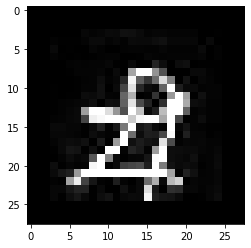

In [84]:
m = x_val[48]+x_val[10]
m =np.clip(m,0,255)
plt.imshow(m,cmap='gray')

In [102]:
gen = generater(3000,200,200)
x_t,y_t = gen.fit_and_generater(x_train,y_train,random_state=2019)
gen.spacing_get

True

In [13]:
gen_val = generater(1000,200,200)
x_v,y_v = gen_val.fit_and_generater(x_val,y_val,random_state=1096)
gen_val.spacing_get

True

In [60]:
gen_test = generater(100,250,250)
gen_test.get_config(scale_range=(0.5,5), is_cube=True, spacing_range=30, rotation_range=(-15,15), rotation_cut=True, num_range=(4,6))
x_t,y_t = gen_test.fit_and_generater(x_val,y_val,random_state=1096)
gen_test.spacing_get

False

In [61]:
to_file(x_t,y_t,'test')

In [96]:
a = x_v
b = y_v

for i in range(a.shape[0]):
    cv2.imwrite(train_dir+'train_image_%d.jpg'%(i),a[i])
    img=cv2.cvtColor(a[i],cv2.COLOR_GRAY2BGR)
    for j in range(len(b[i])):
        cv2.rectangle(img, (b[i][j][0], b[i][j][1]), (b[i][j][2], b[i][j][3]), color_dic[b[i][j][4]], 1)
        cv2.putText(img, '%s'%b[i][j][4], (b[i][j][0], b[i][j][1]-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_dic[b[i][j][4]], 1)
    cv2.imwrite(check_dir+'chech_image_%d.jpg'%(i),img)

f = open('train_info.txt', 'a')
for i in range(len(b)):
    for j in range(len(b[i])):
        f.write(save_dir+'train_image_%d.jpg'%(i))
        for k in range(5):
            f.write(str(b[i][j][k]))
            if k<4:
                f.write(',')
            else:
                f.write('\n')
f.close()

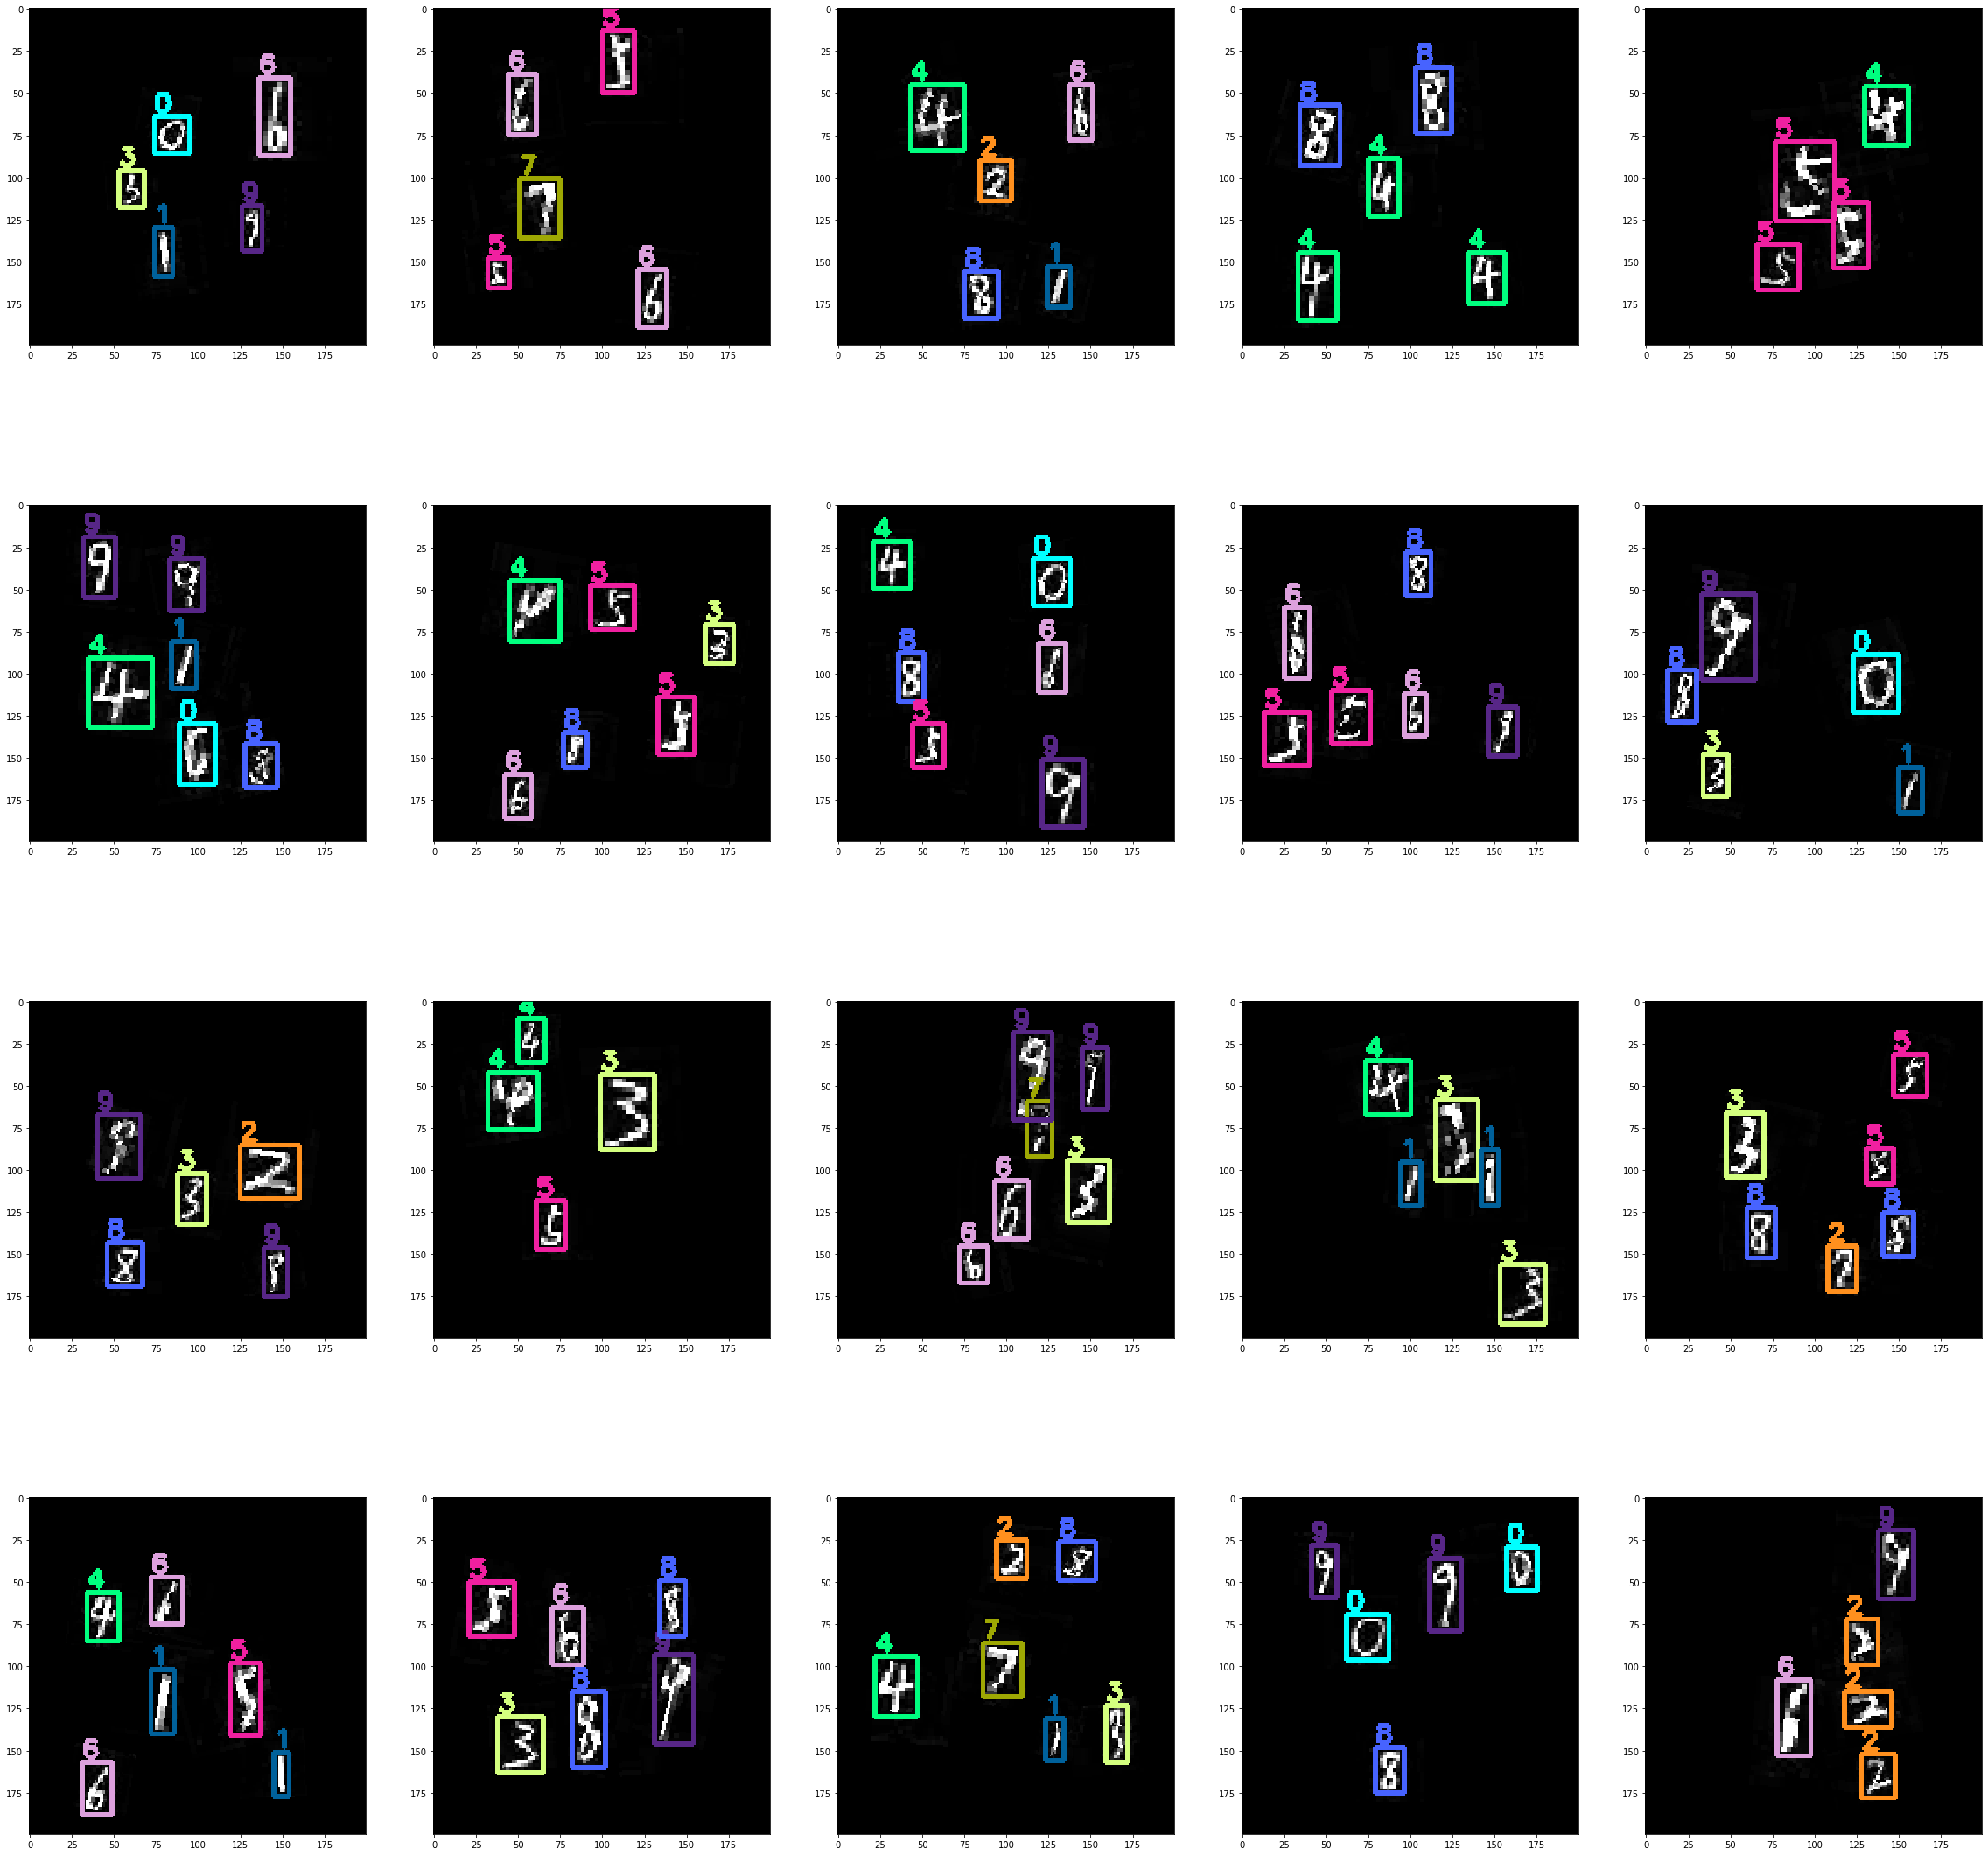

In [103]:
a = x_t
b = y_t
color_dic = [(0,255,255),(0,97,155),(255,144,30),(212,255,127),(0,255,127),(240,32,160),(221,160,221),(158,168,3),(71,99,255),(87,38,135)]
plt.figure(figsize=(40,40))
for i in range(20):
    plt.subplot(4,5,i+1)
    img=cv2.cvtColor(a[i],cv2.COLOR_GRAY2BGR)
    for j in range(len(b[i])):
        cv2.rectangle(img, (b[i][j][0], b[i][j][1]), (b[i][j][2], b[i][j][3]), color_dic[b[i][j][4]], 2)
        cv2.putText(img, '%s'%b[i][j][4], (b[i][j][0], b[i][j][1]-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_dic[b[i][j][4]], 2)
    plt.imshow(img,cmap='gray')

In [31]:
import os
def to_file(a,b,s):
    color_dic = [(0,255,255),(0,97,155),(255,144,30),(212,255,127),(0,255,127),(240,32,160),(221,160,221),(158,168,3),(71,99,255),(87,38,135)]
    s_dir = s+'_image/'
    s_check_dir = s+'_check/'
    try:
        os.mkdir(s_dir)
        os.mkdir(s_check_dir)
    except:
        0

    for i in range(a.shape[0]):
        cv2.imwrite(s_dir+s+'_image_%d.jpg'%(i),a[i])
        img=cv2.cvtColor(a[i],cv2.COLOR_GRAY2BGR)
        for j in range(len(b[i])):
            cv2.rectangle(img, (b[i][j][0], b[i][j][1]), (b[i][j][2], b[i][j][3]), color_dic[b[i][j][4]], 1)
            cv2.putText(img, '%s'%b[i][j][4], (b[i][j][0], b[i][j][1]-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_dic[b[i][j][4]], 1)
        cv2.imwrite(s_check_dir+s+'_chech_%d.jpg'%(i),img)

    f = open(s+'_info.txt', 'a')
    for i in range(len(b)):
        for j in range(len(b[i])):
            f.write(s_dir+s+'_image_%d.jpg,'%(i))
            for k in range(5):
                f.write(str(b[i][j][k]))
                if k<4:
                    f.write(',')
                else:
                    f.write('\n')
    f.close()

In [107]:
to_file(x_t,y_t,'train')

In [116]:
to_file(x_v,y_v,'validation')

In [57]:
to_file(x_t,y_t,'test')